In [1]:
import pandas as pd
import re 
import nltk 
import spacy 
import string 
import os
from spellchecker import SpellChecker
from nltk.corpus import stopwords

In [2]:
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

In [3]:
from copy import copy
import text_hammer as th

In [4]:
def text_preprocessing_from_hammer(df,col_name):
    df = copy(df)
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return df

In [5]:
# https://www.kaggle.com/priyankdl/let-us-start-with-text-processing/notebook
# https://www.kaggle.com/aishwarya2210/prediction-of-tweets-using-bert-model
# https://www.kaggle.com/magicfox94/cleaning-bidirectional-lstm
# https://www.youtube.com/watch?v=LE3NfEULV6k
# https://www.kaggle.com/code/mitramir5/simple-bert-with-video


In [6]:
data_for_training = pd.read_csv('train.csv', header='infer')

In [7]:
texts = data_for_training.loc[:,'text']

In [8]:
# O objetivo do tratamento de dados é diminuir a quantidade de dados para manter o padrão

In [9]:
texts_lowered = texts.str.lower() 

In [10]:
texts_lowered

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610    m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [11]:
mapping_for_punctuation = str.maketrans("","",string.punctuation)
texts_first_clear = texts_lowered.str.translate(mapping_for_punctuation)

In [12]:
# Testes
" ".join(["henrique","mauler","borges"])

'henrique mauler borges'

In [13]:
text_with_soppedwords_cleared = texts_first_clear.apply(lambda words : " ".join(word for word in words.split() if word not in stopwords.words('english')).strip())

In [14]:
from collections import Counter
from collections import defaultdict

counter = defaultdict(int)
for text in text_with_soppedwords_cleared:
    for word in text.split():
        counter[word] += 1
counter_dict = dict(counter)

most_cmn_list = Counter(counter_dict).most_common(20)
most_cmn_words_list = [pof_words[0] for pof_words in most_cmn_list]
most_cmn_words_list

less_cmn_list = Counter(counter_dict).most_common()[:-20]
less_cmn_words_list = [pof_words[0] for pof_words in most_cmn_list]
less_cmn_words_list

another_words_to_remove = [*most_cmn_words_list,*less_cmn_words_list]

In [15]:
text_with_removed_around_words = text_with_soppedwords_cleared.apply(lambda words : " ".join(word for word in words.split() if word not in another_words_to_remove).strip())

In [16]:
from nltk.stem.porter import PorterStemmer

In [17]:
stemmer=PorterStemmer() # Biblioteca para fazer 'stemização', ou seja, retirada dos radicais das palavras para diminuir a amostra de dados

In [18]:
stemmed_words = text_with_removed_around_words.apply(lambda words : " ".join(stemmer.stem(word) for word in words.split()).strip())

In [19]:
html_tag_remover = re.compile('<.*?>')

In [20]:
words_with_html_removed = stemmed_words.apply(lambda words : " ".join(html_tag_remover.sub(r'',word) for word in words.split()).strip())

In [21]:
# Realizando a conversão de chatwords

In [22]:
# Aplicar

In [23]:
from nltk.stem import WordNetLemmatizer

In [24]:
lem=WordNetLemmatizer() # Para fazer lematização das palavras (é como se fosse transformar todas as variações de uma palavra em uma única)

In [25]:
lemmatized_words = words_with_html_removed.apply(lambda words : " ".join(lem.lemmatize(word) for word in words.split()).strip())

In [26]:
data_for_training.loc[:,"cleared_words"] = lemmatized_words

In [27]:
data_for_training

,id,keyword,location,text,target,cleared_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrari thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,investig ebik collid car littl portug ebik rid...


In [28]:
data_for_training_hammed = text_preprocessing_from_hammer(data_for_training,'cleared_words')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [29]:
# SOLID
data_for_training = data_for_training_hammed

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

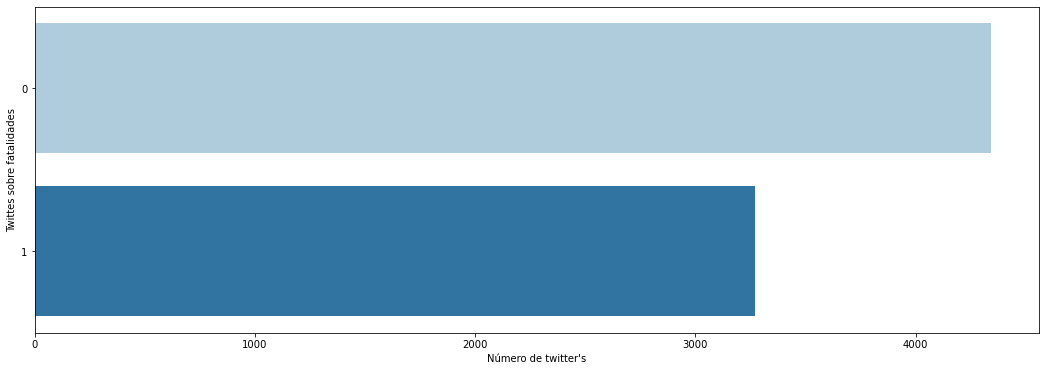

In [31]:
plt.figure(figsize=(18,6))
sns.countplot(y='target',data = data_for_training,palette="Paired")
plt.ylabel("Twittes sobre fatalidades")
plt.xlabel("Número de twitter's")
plt.show()

In [32]:
train_data = data_for_training.loc[:,["id","cleared_words","target"]].rename(columns = {"cleared_words" : "words"})

In [33]:
forma_cases = train_data[train_data.target == 0]
diaster_cases = train_data[train_data.target == 1]

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

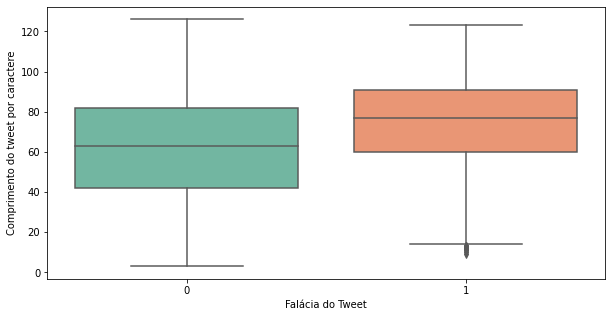

In [35]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['words'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Falácia do Tweet")
plt.ylabel("Comprimento do tweet por caractere")
plt.show()

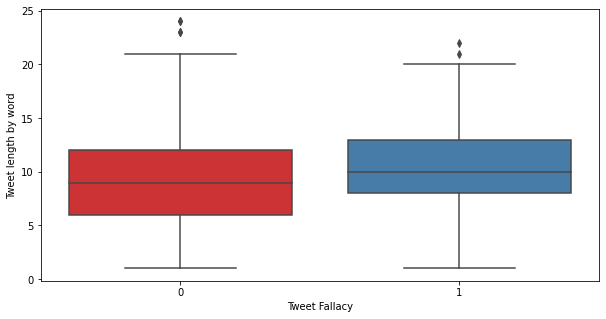

In [36]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['words'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [37]:
train_data['word_count'] = train_data['words'].apply(lambda x : len(str(x).split()))

In [38]:
train_data['unique_word_count'] = train_data['words'].apply(lambda x : len(set(str(x).split())))

In [39]:
STOPWORDS = tuple(set(stopwords.words('english')))

In [40]:
import numpy

In [41]:
# word_count
train_data['word_count'] = train_data['words'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['words'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['words'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

train_data['url_count'] = train_data['words'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

train_data['mean_word_length'] = train_data['words'].apply(lambda x: numpy.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['words'].apply(lambda x: len(str(x)))

C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

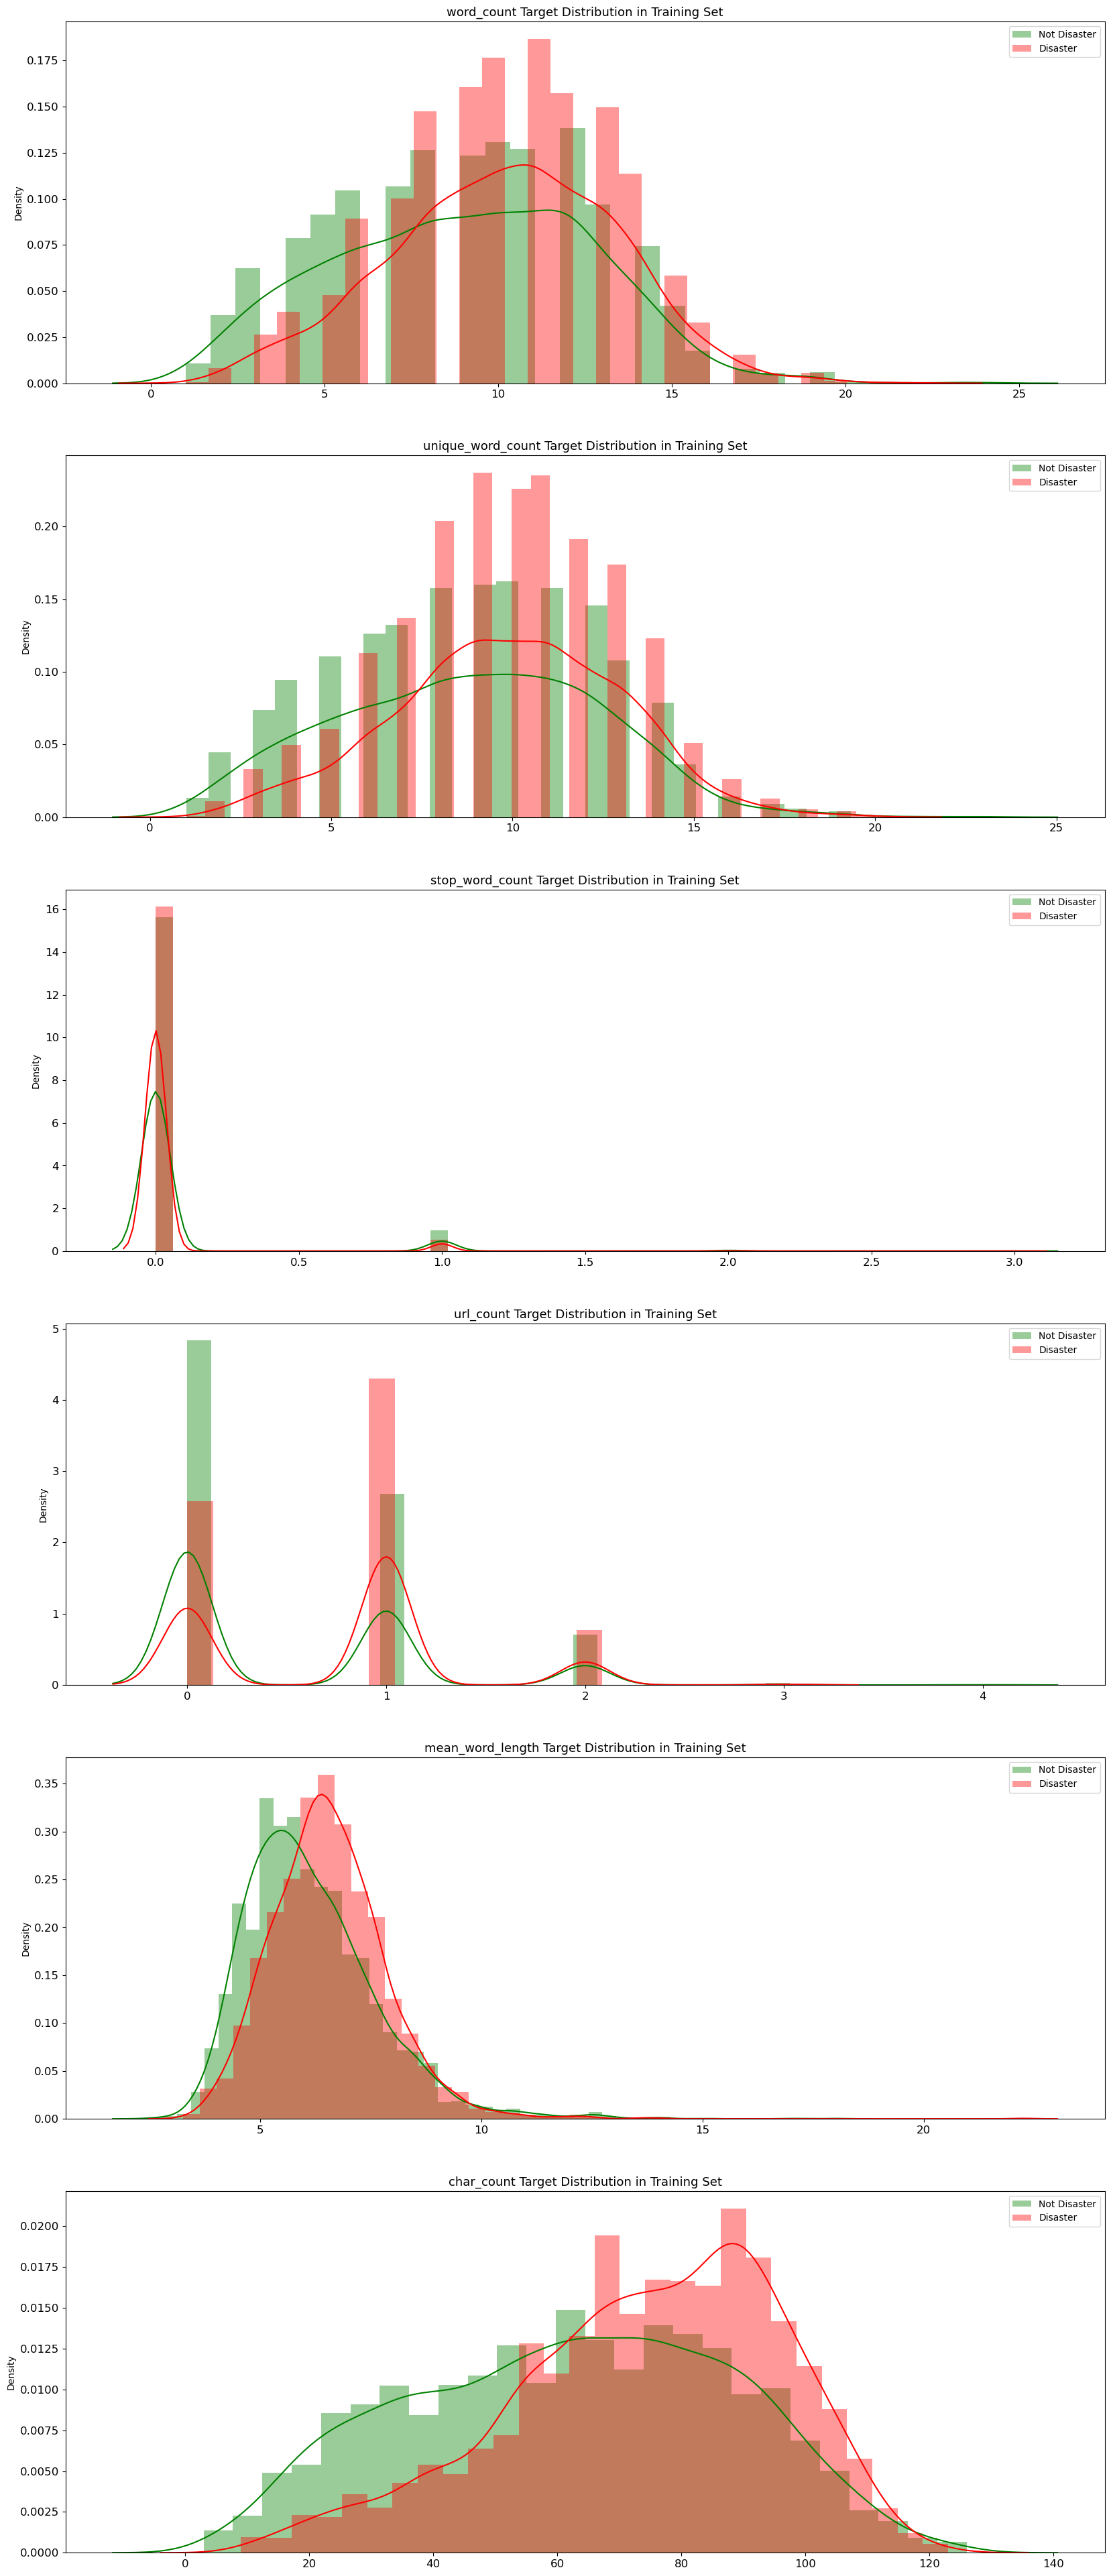

In [42]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='red')

    # sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    # sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    # axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [43]:
# Trazer mais gráficos para apresentação

In [44]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [45]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

In [48]:
training_data = data_for_training.loc[:,["id","cleared_words","target"]].rename(columns = {"cleared_words" : "text"})

In [49]:
training_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [50]:
max_len = 36

In [75]:
training_data.head()

,id,text,target
0,1,deed reason earthquak may allah forgiv,1
1,4,forest near la rong sask canada,1
2,5,resid ask shelter place notifi offic evacu she...,1
3,6,13000 receiv wildfir evacu order california,1
4,7,got sent photo rubi alaska smoke wildfir pour ...,1


In [51]:
x_train = tokenizer(
    text=training_data.text.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [52]:
x_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [53]:
y_train = training_data.target.values

In [54]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [85]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [86]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 36, 1024), ( 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 1024)         0           tf_bert_model[2][1]   

In [66]:
optimizer = Adam(
    learning_rate = 6e-06,
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0
)

In [67]:
loss = BinaryCrossentropy(from_logits = True)

In [68]:
metric = BinaryAccuracy('accuracy')

In [91]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric
)

In [ ]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9,
    batch_size=10
)

Epoch 1/9
  1/762 [..............................] - ETA: 0s - loss: 0.7333 - accuracy: 0.4000

In [90]:
final = model.fit(

    x = {
        'input_ids' : x_train['input_ids'],
        'attention_mask' : x_train['attention_mask']
    },
    y = y_train,
    epochs = 9,
    batch_size = 10
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.